# CSCI-UA 0473 - Introduction to Machine Learning
## Monday, February 12, 2018

This lab will discuss briefly about *overfitting*, and various approaches to deal with it.

### 1. Overfitting

To quote [Wikipedia](https://en.wikipedia.org/wiki/Overfitting):
> In statistics, **overfitting** is "the production of an analysis that corresponds too closely or exactly to a particular set of data, and may therefore fail to fit additional data or predict future observations reliably".

Several scenarios, and their combinations, would increase the chance of overfitting, hence a larger generalization error:
* Lack of data (especially when compared to the size of feature space and/or model capacity)
* Inherent noise in data
* [Data leakage](https://www.kaggle.com/wiki/Leakage), including using unexpected features correlated to the target variable for prediction (e.g. using object ID to predict object class).

Example of overfitting for classification:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/1/19/Overfitting.svg/300px-Overfitting.svg.png)

And another one for regression:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Overfitted_Data.png/300px-Overfitted_Data.png)

(Both images taken from Wikipedia)

Solutions to aim for a better generalization error includes
* Collecting more data.  Often the best solution, **provided that you can afford the cost**.
* Cutting off model capacity, the most common form of which is *regularization*, to reduce overfitting.
* Validation-set-based model selection, including *early stopping* (to mitigate overfitting) and *hyperparameter search*.

The following is a demonstration of logistic regression overfitting on some 2D toy data.  Overfitting is best observed when you use complex models, and/or on high-dimensional features.  But since we have yet come to that, we will see how a simple model would overfit in a low-data regime, even with low-dimensional feature space.

First, let's create some toy data:

In [1]:
%matplotlib inline 

import autograd.numpy as np
import autograd.numpy.random as npr

from autograd import value_and_grad

import scipy.optimize
import matplotlib.pyplot as plot
import matplotlib.animation as animation

npr.seed(1234)

from sklearn.datasets import make_blobs
n_dim = 2
x_tra, y_tra = make_blobs(n_samples=20, n_features=n_dim, centers=[[1,1],[-1,-1]], shuffle=True)
x_val, y_val = make_blobs(n_samples=20, n_features=n_dim, centers=[[1,1],[-1,-1]], shuffle=True)
x_tes, y_tes = make_blobs(n_samples=100, n_features=n_dim, centers=[[1,1],[-1,-1]], shuffle=True)

In [2]:
# A mess for visualization...
def vis_data(ax, x, y = None, marker='r.', pos_marker='r.', neg_marker='b.'):
    if y is None: 
        y = [None] * len(x)
    for x_, y_ in zip(x, y):
        if y_ is None:
            ax.plot(x_[0], x_[1], marker)
        else:
            ax.plot(x_[0], x_[1], neg_marker if y_ == 0 else pos_marker)
    ax.grid('on')
def vis_hyperplane(ax, w, typ='k--', label=None):

    lim0 = ax.get_xlim()
    lim1 = ax.get_ylim()
    m0, m1 = lim0[0], lim0[1]

    intercept0 = -(w[0] * m0 + w[-1])/w[1]
    intercept1 = -(w[0] * m1 + w[-1])/w[1]
    
    plt1, = ax.plot([m0, m1], [intercept0, intercept1], typ, label=label)

    ax.set_xlim(lim0)
    ax.set_ylim(lim1)
    
    return plt1

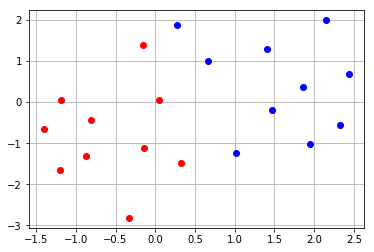

In [18]:
fig, ax = plot.subplots()
vis_data(ax, x_tra, y_tra, pos_marker='ro', neg_marker='bo')
#vis_data(ax, x_tes, y_tes, pos_marker='r+', neg_marker='b+')
plot.show()

Now we need to build a logistic regression model.

<div class="alert alert-warning">
**Beware**: The following logistic regression implementation is still numerically unstable.  ~~Unfortunately~~ We decided to leave such implementation as one of your homework assignment.  Don't worry - we prepared a guide for deriving a proper implementation.
</div>

In [4]:
def score(x, params):
    w, b = params[:-1], params[-1]
    return x @ w + b # replace this to np.dot(x, w) + b if @ doesn't work

def predict(x, params):
    return score(x, params) > 0

def logreg_cost(params, x, y, lambda_=0):
    s = score(x, params)
    prob = 1 / (1 + np.exp(-s)) # sigmoid
    cost = -(y * np.log(prob) + (1 - y) * np.log(1 - prob))
    return cost.mean() + lambda_ * (params ** 2).sum() # if lambda_ > 0, then we have a regularized model (will come to this later)

For the purpose of demonstration and an easier implementation of early stopping, we do not use `scipy.optimize.minimize()` here.  Instead, we perform a normal gradient descent by our own.

Recall that given the parameters $\mathbf{w}$ and the gradient of the cost function $\nabla_\mathbf{w} \mathcal{L}$ w.r.t. the parameters, the update rule for normal gradient descent is

$$
\mathbf{w} \gets \mathbf{w} - \alpha \nabla_\mathbf{w} \mathcal{L}
$$

where $\alpha$ is some value picked before the training process (a.k.a. *hyperparameter*).  Usually it is called *learning rate*.

In [5]:
def train_model(x_train, y_train, params, cost_fn, lambda_=0, learning_rate=0.1, n_iter=2000, keep_history=False):
    '''
    x_train: a 2D array with shape (n_samples, n_features)
    y_train: a 1D array of 0's and 1's, with shape (n_samples,)
    params: initial parameter array
    cost_fn: a cost function we wish to minimize
    lambda_: the same lambda_ that will be fed into the cost function.
    learning_rate: see above
    n_iter: the maximum number of iterations
    keep_history: if True, returns a series of historical parameter arrays throughout the optimization instead
    
    returns a parameter array that minimizes cost_fn(params, x_train, y_train, lambda_) via gradient descent.
    '''
    # value_and_grad returns a function that compute the cost function and the gradient simultaneously
    cost_and_grad = value_and_grad(cost_fn, 0)
    best_cost = np.inf
    best_params = None
    
    if keep_history:
        history = []
    # Iteratively perform gradient descent
    for i in range(n_iter):
        # compute the cost and gradient
        cost, dparams = cost_and_grad(params, x_train, y_train, lambda_=lambda_)
        
        if best_cost > cost:
            best_cost = cost
            best_params = params
        if keep_history:
            history.append(params)
        # update
        params = params - dparams * learning_rate
        
    return best_params if not keep_history else np.array(history)

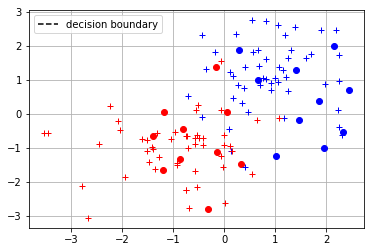

In [6]:
from IPython.display import HTML
def train_and_animate(x_tra, y_tra, x_tes, y_tes, lambda_=0):
    n_dim = x_tra.shape[1]
    params0 = npr.randn(n_dim + 1) * 0.01
    params_history = train_model(x_tra, y_tra, params0, logreg_cost, keep_history=True, lambda_=lambda_)

    # Yet another mess for visualization all the way to the end...
    fig, ax = plot.subplots()
    vis_data(ax, x_tra, y_tra, pos_marker='ro', neg_marker='bo')
    vis_data(ax, x_tes, y_tes, pos_marker='r+', neg_marker='b+')
    line = vis_hyperplane(ax, params_history[0], label='decision boundary')
    ax.legend(loc='best')

    def set_intercepts(line, ax, w):
        lim0 = ax.get_xlim()
        lim1 = ax.get_ylim()
        m0, m1 = lim0[0], lim0[1]

        intercept0 = -(w[0] * m0 + w[-1])/w[1]
        intercept1 = -(w[0] * m1 + w[-1])/w[1]
        line.set_data([m0, m1], [intercept0, intercept1])

    def animate(t):
        set_intercepts(line, ax, params_history[t])
        return line,

    def init():
        set_intercepts(line, ax, params_history[0])
        return line,

    ani = animation.FuncAnimation(fig, animate, np.arange(0, 2000, 10), init_func=init,
                                  interval=100, blit=False)
    return ani
    
ani = train_and_animate(x_tra, y_tra, x_tes, y_tes)
HTML(ani.to_html5_video())

### 2. Regularization

Regularization is a way to limit the model capacity by either constraining or penalizing the weight magnitudes.  It can be applied to any parametric models.

The most common regularization is probably *L2 regularization*, which adds a penalty proportional to the L2-norm of the weight:
$$
J_\mathrm{reg}(D_\mathrm{tra}, \mathbf{w}) = J(D_\mathrm{tra}, \mathbf{w}) + \dfrac{\lambda}{2} \lVert \mathbf{w} \rVert^2
$$
It is also called *weight decay* presumably because the gradient of $\mathbf{w}$ has a correction term proportional to $\mathbf{w}$ itself:
$$
\nabla_\mathbf{w} J_\mathrm{reg}(D_\mathrm{tra}, \mathbf{w}) = \nabla_\mathbf{w} J(D_\mathrm{tra}, \mathbf{w}) + \lambda \mathbf{w}
$$

Intuitively, the term $\dfrac{\lambda}{2} \lVert \mathbf{w} \rVert^2$ encodes our *belief* that the parameters should not be too large.  The belief is stronger if $\lambda$ is larger.

<div class="alert alert-info">
**Math**: If we consider the original cost function $J$ as some negative log-likelihood function (such as the one being used in logistic regression), and regard $\dfrac{\lambda}{2} \lVert \mathbf{w} \rVert^2$ as yet another negative log-likelihood term, we can see that L2 regularization is equivalent to saying that "*We believe our parameters to come from a Gaussian centered at 0*".
</div>

Now let's run another experiment on the same training set and test set, but with $\lambda$ cranked up.

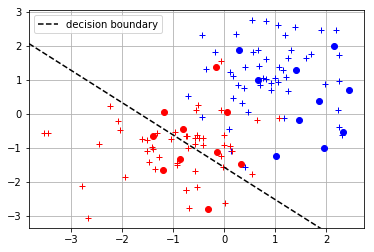

In [7]:
ani = train_and_animate(x_tra, y_tra, x_tes, y_tes, 0.1)
HTML(ani.to_html5_video())

It seems that, indeed the regularized logistic regression does generalize better.  However, L2 regularization is not something applicable to any situation.

<div class="alert alert-danger">
**Question**: What if we shift the entire dataset away from the origin (say, 2 units up and 2 units right)?  Run the following cell and see what happens.  What should we do before training so that regularization can have the chance to help?
</div>

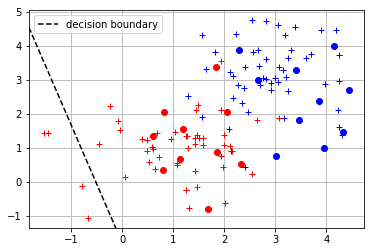

In [8]:
ani = train_and_animate(x_tra + 2, y_tra, x_tes + 2, y_tes, 0.1)
HTML(ani.to_html5_video())

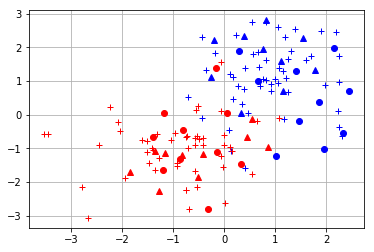

In [9]:
fig, ax = plot.subplots()
vis_data(ax, x_tra, y_tra, pos_marker='ro', neg_marker='bo')
vis_data(ax, x_val, y_val, pos_marker='r^', neg_marker='b^')
vis_data(ax, x_tes, y_tes, pos_marker='r+', neg_marker='b+')
plot.show()

### 3. Validation-set-based model selection

Usually, what we care about in machine learning is the performance on the unseen test set, rather than the training set where the model is tuned.  If we split out some of the training set to form a *validation set*, and train the model on the rest of the training set, we can then select a model which has the least *validation error*, and hope that the test error is small as well.

<div class="alert alert-warning">
**Beware**: As soon as you *pick* the model with best validation error, the error itself is no longer a good estimate of (expected) test error.
</div>

Both *early stopping* and *hyperparameter search* are based on this intuition.

#### 3.1 Early Stopping

The idea of early stopping is simple: if we didn't see any significant improvement on validation error for a certain period, we say "this is it" and stop.  However, different people have different definitions on which improvements are *significant*, and how long a *certain* period should be.  The fluctuation of validation error further complicates the implementation of early stopping.

As a demonstration, we stop after the model did not improve over the best validation *accuracy* in 30 gradient steps.  Though in the following implementation, we go all the way to the end anyway, to better visualize the difference between an early-stopping-selected model, the model with "truly"-best validation error, and the model with best training loss.

If you are interested in which early stopping criteria is more commonly used, see [here](https://keras.io/callbacks/#earlystopping) and [here](http://deeplearning.net/tutorial/gettingstarted.html#early-stopping).

<div class="alert alert-warning">
**Caveat**: In this lab, the validation set is separately generated rather than picking from the training set.  But often times, you are not able to do so (e.g. with a fixed-size training set and no easy way to acquire new samples).
</div>

<div class="alert alert-warning">
**Beware**: Make sure that the validation set does not appear in the dataset for optimization.  Make sure that the test set does not appear in the dataset for optimization **AND** validation.
</div>

<div class="alert alert-danger">
Please answer the question in the cell below.
</div>

In [10]:
def train_model_with_early_stopping(
    x_train, y_train, x_valid, y_valid, params, cost_fn, valid_fn, lambda_=0, learning_rate=0.1, n_iter=2000, keep_history=False):
    '''
    x_train: a 2D array with shape (n_samples, n_features)
    y_train: a 1D array of 0's and 1's, with shape (n_samples,)
    x_valid, y_valid: same, but for validation
    params: initial parameter array
    cost_fn: a cost function we wish to minimize
    valid_fn: a cost function for validation error
    lambda_: the same lambda_ that will be fed into the cost function.
    learning_rate: see above
    n_iter: the maximum number of iterations
    keep_history: if True, returns a series of historical parameter arrays throughout the optimization instead
    
    returns a parameter array that minimizes cost_fn(params, x_train, y_train, lambda_) via gradient descent.
    '''
    # value_and_grad returns a function that compute the cost function and the gradient simultaneously
    cost_and_grad = value_and_grad(cost_fn, 0)
    best_validation_cost = np.inf
    early_stopped = False
    best_params = params
    early_stopped_params = params
    best_iter = 0
    
    if keep_history:
        history = []
        early_stopping_history = []
        best_validation_history = []
    # Iteratively perform gradient descent
    for i in range(n_iter):
        # compute the cost and gradient
        cost, dparams = cost_and_grad(params, x_train, y_train, lambda_=lambda_)
        # QUESTION:
        # Why are we using a separate validation error function, different from the training cost function here?
        validation_cost = valid_fn(params, x_valid, y_valid)
        
        if best_validation_cost > validation_cost:
            best_validation_cost = validation_cost
            best_iter = i
            best_params = params
            if not early_stopped:
                early_stopped_params = params
        elif i > best_iter + 30:
            early_stopped = True
            # Usually we should break out but I'm continuing the training for visualization purposes
            #break

        if keep_history:
            history.append(params)
            early_stopping_history.append(early_stopped_params)
            best_validation_history.append(best_params)
        # update
        params = params - dparams * learning_rate
        
    return early_stopped_params if not keep_history else (history, early_stopping_history, best_validation_history)

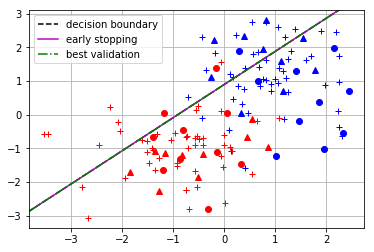

In [11]:
from sklearn.metrics import accuracy_score

def accuracy_error(params, x, y):
    # Not very intuitive, but this essentially means the higher the accuracy the better,
    # since the training procedure above picks the model with the *least* validation error.
    return 1 - accuracy_score(y, predict(x, params))

def train_with_early_stopping_and_animate(x_tra, y_tra, x_val, y_val, x_tes, y_tes, lambda_=0):
    n_dim = x_tra.shape[1]
    params0 = npr.randn(n_dim + 1) * 0.01
    params_history, early_stopping_history, best_validation_history = train_model_with_early_stopping(
        x_tra, y_tra, x_val, y_val, params0, logreg_cost, accuracy_error, keep_history=True, lambda_=lambda_)

    # Again a gigantic piece for visualization...
    fig, ax = plot.subplots()
    vis_data(ax, x_tra, y_tra, pos_marker='ro', neg_marker='bo')
    vis_data(ax, x_val, y_val, pos_marker='r^', neg_marker='b^')
    vis_data(ax, x_tes, y_tes, pos_marker='r+', neg_marker='b+')
    line = vis_hyperplane(ax, params_history[0], label='decision boundary')
    early_stopping_line = vis_hyperplane(ax, early_stopping_history[0], 'm-', label='early stopping')
    best_validation_line = vis_hyperplane(ax, best_validation_history[0], 'g-.', label='best validation')
    ax.legend(loc='best')

    def set_intercepts(line, ax, w):
        lim0 = ax.get_xlim()
        lim1 = ax.get_ylim()
        m0, m1 = lim0[0], lim0[1]

        intercept0 = -(w[0] * m0 + w[-1])/w[1]
        intercept1 = -(w[0] * m1 + w[-1])/w[1]
        line.set_data([m0, m1], [intercept0, intercept1])

    def animate(t):
        set_intercepts(line, ax, params_history[t])
        set_intercepts(early_stopping_line, ax, early_stopping_history[t])
        set_intercepts(best_validation_line, ax, best_validation_history[t])
        return line, early_stopping_line, best_validation_line

    def init():
        set_intercepts(line, ax, params_history[0])
        set_intercepts(early_stopping_line, ax, early_stopping_history[0])
        set_intercepts(best_validation_line, ax, best_validation_history[0])
        return line, early_stopping_line, best_validation_line

    ani = animation.FuncAnimation(fig, animate, np.arange(0, 2000, 10), init_func=init,
                                  interval=100, blit=False)
    return ani
    
ani = train_with_early_stopping_and_animate(x_tra, y_tra, x_val, y_val, x_tes, y_tes)
HTML(ani.to_html5_video())

#### 3.2 Hyperparameter search

Hyperparameter search is yet another simple, brute-force-ish idea to opt for a better generalization error.  Basically, we specify the range to search for each hyperparameter, no matter if they are continuous or discrete, and we either exhaustively try every combination (*grid search*), or test a bunch of those (*random search*), and choose the configuration with the best validation error.

<div class="alert alert-danger">
Please modify the following function, so that it exhaustively try every $\lambda$ given in the list, returning the best model.  You don't need to save history for anything.
</div>

In [16]:
def train_model_with_early_stopping_and_grid_search(
    x_train, y_train, x_valid, y_valid, params, cost_fn, valid_fn, lambda_=0, learning_rate=0.1, n_iter=2000):
    '''
    x_train: a 2D array with shape (n_samples, n_features)
    y_train: a 1D array of 0's and 1's, with shape (n_samples,)
    x_valid, y_valid: same, but for validation
    params: initial parameter array
    cost_fn: a cost function we wish to minimize
    valid_fn: a cost function for validation error
    lambda_: a list of lambda's
    learning_rate: see above
    n_iter: the maximum number of iterations
    
    returns a parameter array that minimizes cost_fn(params, x_train, y_train, lambda_) via gradient descent.
    '''
    # value_and_grad returns a function that compute the cost function and the gradient simultaneously
    params0 = np.copy(params)
    cost_and_grad = value_and_grad(cost_fn, 0)
    best_validation_cost = np.inf
    early_stopped = False
    best_params = params
    early_stopped_params = params
    best_iter = 0
    grid_search_params = params
    grid_search_error = np.inf
    
    # Iteratively perform gradient descent
    for l in lambda_:
        params = params0
        best_validation_cost = np.inf
        for i in range(n_iter):
            # compute the cost and gradient
            cost, dparams = cost_and_grad(params, x_train, y_train, lambda_=l)
            assert cost.ndim == 0
            validation_cost = valid_fn(params, x_valid, y_valid)
         
            if best_validation_cost > validation_cost:
                best_validation_cost = validation_cost
                best_iter = i
                best_params = params
                if not early_stopped:
                    early_stopped_params = params
            elif i > best_iter + 30:
                early_stopped = True
                # Usually we should break out but I'm continuing the training for visualization purposes
                break

            # update
            params = params - dparams * learning_rate
        if grid_search_error > best_validation_cost:
            grid_search_error = best_validation_cost
            grid_search_params = params
        
    return grid_search_params

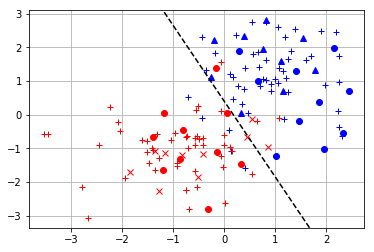

In [17]:

params0 = npr.randn(n_dim + 1) * 0.01
params = train_model_with_early_stopping_and_grid_search(
    x_tra, y_tra, x_val, y_val, params0, logreg_cost, accuracy_error, lambda_=[0, 0.1])

fig, ax = plot.subplots()
vis_data(ax, x_tra, y_tra, pos_marker='ro', neg_marker='bo')
vis_data(ax, x_val, y_val, pos_marker='rx', neg_marker='b^')
vis_data(ax, x_tes, y_tes, pos_marker='r+', neg_marker='b+')
line = vis_hyperplane(ax, params, label='decision boundary')
plot.show()

### 4. See also

`scikit-learn` has a whole set of tools for model selection, with hyperparameter search and (cross-)validation wrapped up as `scikit-learn` models; see http://scikit-learn.org/stable/modules/grid_search.html for details.  Notably, they have `sklearn.model_selection.GridSearchCV` and `sklearn.model_selection.RandomizedSearchCV` to do the dirty work.